# Aim:

- Convert interactive datatable in HTML file to Pandas DataFrame
  
- Inspecting the difference between the library prepared with 1/5V and 1V

In [303]:
import os
import pandas as pd
import re
import json
import datetime

import rpy2 # using R in Python code
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr 
utils = importr('utils') # import the R functions

# display R objects such as data frames in HTML
import rpy2.ipython.html
rpy2.ipython.html.init_printing()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [304]:
###### setting working directory
master_dir = "/Users/binhvo/Library/CloudStorage/OneDrive-Personal/Documents_Mac/Ebooks/Python/Learning_myself/Python_practice/QC_b4_after_0.2V"
os.chdir(master_dir)

In [305]:
###### check how many folders there are
os.listdir()

['before_pct20V',
 'CR_inspecting.html',
 '.DS_Store',
 'pct_off_bait_3_groups.png',
 'pct20V_after_increase_input',
 'pct_off_bait_3_groups_mod.png',
 'pct20V_before_increase_input']

In [306]:
###### add those folder to the list of directories

# create a empty list
sub_dir=[]

# iterate over folders in master_dir
# then append to the list
for i in os.listdir():
    if os.path.isdir(i): # check if i is a folder
        folder = f'{master_dir}/{i}'
        sub_dir.append(folder)

In [307]:
# sanity check, printing all sub-folders
sub_dir

['/Users/binhvo/Library/CloudStorage/OneDrive-Personal/Documents_Mac/Ebooks/Python/Learning_myself/Python_practice/QC_b4_after_0.2V/before_pct20V',
 '/Users/binhvo/Library/CloudStorage/OneDrive-Personal/Documents_Mac/Ebooks/Python/Learning_myself/Python_practice/QC_b4_after_0.2V/pct20V_after_increase_input',
 '/Users/binhvo/Library/CloudStorage/OneDrive-Personal/Documents_Mac/Ebooks/Python/Learning_myself/Python_practice/QC_b4_after_0.2V/pct20V_before_increase_input']

In [308]:
###### define a function that converts interactive datatable in a HTML file to Pandas DataFrame
def convert_to_df(input):
    """
        input is a absolute path.
        all used ref:
        1. https://www.geeksforgeeks.org/python-program-convert-string-list/ : Method 6: using JSON
        2. https://datatofish.com/list-to-dataframe/ : transpose
        3. https://stackoverflow.com/questions/3368969/find-string-between-two-substrings : retrieve string between two patterns using 're'
        4. https://stackoverflow.com/questions/33417208/how-to-get-source-code-of-html-file-and-put-in-string : convert HTML file to source code

    """
    base_name = os.path.basename(input)
    dir_name = os.path.dirname(input)
    html_file = open(input, 'r') # open HTML file
    html_string = html_file.read() # read that file as a source code
    object = re.search('"data":(.*),"container"', html_string) # retrieve the interactive table stored between the pattern: -- "data": -- and -- ,"container" --
    sample_list = object.group(1) # extract sample list
    sample_list_mod = json.loads(sample_list) # using JSON function to convert a JSON-like list to dataframe
    df = pd.DataFrame(sample_list_mod).transpose() # without 'transpose', the output dataframe had a wrong format. You should check by yourself.
    df.columns = [['SampleID',
                    'PF_UNIQUE_READS',
                    'PCT_OFF_BAIT',
                    'MEAN_BAIT_COVERAGE',
                    'MEAN_TARGET_COVERAGE',
                    'ZERO_CVG_TARGETS_PCT',
                    'PCT_TARGET_BASES_10X',
                    'PCT_TARGET_BASES_20X']] # name those columns
    df['Run'] = base_name.split(".")[0] # create a column storing Run information which has patttern like 'Rxxx.qc.html'
    file_name = base_name.split(".")[0] # create a file name of the output csv file
    df.to_csv(f'{dir_name}/{file_name}.csv', index = False)

In [309]:
###### convert interactive datatable in HTML file to Pandas DataFrame

# iterate over all sub-folders in master_dir
# then take HTML file as a input of the defined function

# cited: https://stackoverflow.com/questions/237079/how-do-i-get-file-creation-and-modification-date-times
# print created time in human-readable format
# Christian Oudard's comment
noti_list = []
for folder in sub_dir:
    for file in os.listdir(folder):
        if str(file).endswith('.qc.html'): # check if file is a HTML file
            run_name = file.split(".")[0] # extract run name
            # created_time = os.path.getctime(f'{folder}/{run_name}.csv') # extract created time of CSV file if it existed.
            if os.path.exists(f'{folder}/{run_name}.csv'): # check if CSV file exists
                # print(f'File {run_name}.csv \t \t existed at \t {datetime.datetime.fromtimestamp(created_time)}')
                noti_list.append('File existed')
            else:
                noti_list.append('File did not exist')
                target = f'{folder}/{file}'
                convert_to_df(target)

# using set function to unique a list
# cited: https://stackoverflow.com/questions/12897374/get-unique-values-from-a-list-in-python
# lefterav's comment
print(set(noti_list)) # check if all of files existed, i.e. output only has the pattern 'File existed', else the output will print 'File did not exist'

{'File existed'}


In [310]:
###### define a function to concatenate all csv files in a sub-folder into a dataframe
def concat_df(input):
    """
        input is a folder
        iterate over files in folder then concat them vertically
        cited: https://stackoverflow.com/questions/66906228/looping-through-csv-files-to-create-concatenated-dataframe-need-to-use-date-in
    """
    list_df = [] # create a empty list
    for file in os.listdir(input):
        if str(file).endswith('.csv'): # check if file is a CSV file
            df = pd.read_csv(f'{input}/{file}', index_col=None, header=0)
            list_df.append(df) # add data to list
    after_increased = pd.concat(list_df, axis=0, ignore_index=True) # concatenate vertically with option 'axis=0'
    return after_increased # export data when done

In [311]:
# call concat_df function
before_pct20V = concat_df(sub_dir[0])
after_increase_input = concat_df(sub_dir[1])
before_increase_input = concat_df(sub_dir[2])

In [312]:
# create a column storing group information
before_pct20V['Group'] = 'before_pct20V'
after_increase_input['Group'] = 'after_increase_input'
before_increase_input['Group'] = 'before_increase_input'

In [313]:
# sanity check
print(before_pct20V.head(0))
print(after_increase_input.head(0))
print(before_increase_input.head(0))

Empty DataFrame
Columns: [SampleID, PF_UNIQUE_READS, PCT_OFF_BAIT, MEAN_BAIT_COVERAGE, MEAN_TARGET_COVERAGE, ZERO_CVG_TARGETS_PCT, PCT_TARGET_BASES_10X, PCT_TARGET_BASES_20X, Run, Group]
Index: []
Empty DataFrame
Columns: [SampleID, PF_UNIQUE_READS, PCT_OFF_BAIT, MEAN_BAIT_COVERAGE, MEAN_TARGET_COVERAGE, ZERO_CVG_TARGETS_PCT, PCT_TARGET_BASES_10X, PCT_TARGET_BASES_20X, Run, Group]
Index: []
Empty DataFrame
Columns: [SampleID, PF_UNIQUE_READS, PCT_OFF_BAIT, MEAN_BAIT_COVERAGE, MEAN_TARGET_COVERAGE, ZERO_CVG_TARGETS_PCT, PCT_TARGET_BASES_10X, PCT_TARGET_BASES_20X, Run, Group]
Index: []


In [314]:
###### merge all dataframe to a full dataframe
full_df = pd.concat([before_pct20V, after_increase_input, before_increase_input], ignore_index=True)

In [315]:
# sanity check
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19403 entries, 0 to 19402
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SampleID              19403 non-null  object 
 1   PF_UNIQUE_READS       19403 non-null  int64  
 2   PCT_OFF_BAIT          19403 non-null  float64
 3   MEAN_BAIT_COVERAGE    19403 non-null  float64
 4   MEAN_TARGET_COVERAGE  19403 non-null  float64
 5   ZERO_CVG_TARGETS_PCT  19403 non-null  float64
 6   PCT_TARGET_BASES_10X  19403 non-null  float64
 7   PCT_TARGET_BASES_20X  19403 non-null  float64
 8   Run                   19403 non-null  object 
 9   Group                 19403 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 1.5+ MB


In [316]:
%%R --input before_pct20V,after_increase_input,before_increase_input,full_df

print(head(full_df, 3))

# import dataframe from Python to R

        SampleID PF_UNIQUE_READS PCT_OFF_BAIT MEAN_BAIT_COVERAGE
0  1-JXQJ49_S458          456249     0.524180           2040.852
1 10-AAZK86_S467          434441     0.524751           1845.593
2 11-AAZK87_S468          423436     0.530214           1942.006
  MEAN_TARGET_COVERAGE ZERO_CVG_TARGETS_PCT PCT_TARGET_BASES_10X
0             56.58067             0.017094             0.983076
1             44.39681             0.017094             0.980275
2             28.99342             0.025641             0.977596
  PCT_TARGET_BASES_20X   Run         Group
0             0.976866 R2988 before_pct20V
1             0.968160 R2988 before_pct20V
2             0.873859 R2988 before_pct20V


### Inspecting PCT_OFF_BAIT of each run in each group

In [317]:
%%R
library(ggplot2)

# define a function for plotting
plot_graph <- function(input_df){
    """
        input is a dataframe having PCT_OFF_BAIT and Run columns
        all used ref:
        1. https://stackoverflow.com/questions/14577412/how-to-convert-variable-object-name-into-string : convert variable's name to string
        2. https://thomasadventure.blog/posts/turning-your-ggplot2-code-into-a-function/ : using ggplot in a function
    """
    name <- deparse(substitute(input_df)) # convert variable's name to string
    ggplot(data = input_df,
    aes(
        x = PCT_OFF_BAIT,
        y = Run
    )) +
    geom_violin(alpha = 0.5) +
    stat_summary(
                fun.data = "mean_cl_boot",
                geom = "pointrange",
                size = 0.09,
                colour = "blue") +
    labs(title = name) +
    theme(
        axis.text.y = element_text(angle = 45),
        plot.title = element_text(size = 10)
    ) +
    scale_x_continuous(breaks=seq(0.4, 1, 0.1)) +
    xlab(NULL) +
    ylab(NULL)
}

# call the function
p1 <- plot_graph(before_pct20V)
p2 <- plot_graph(before_increase_input)
p3 <- plot_graph(after_increase_input)

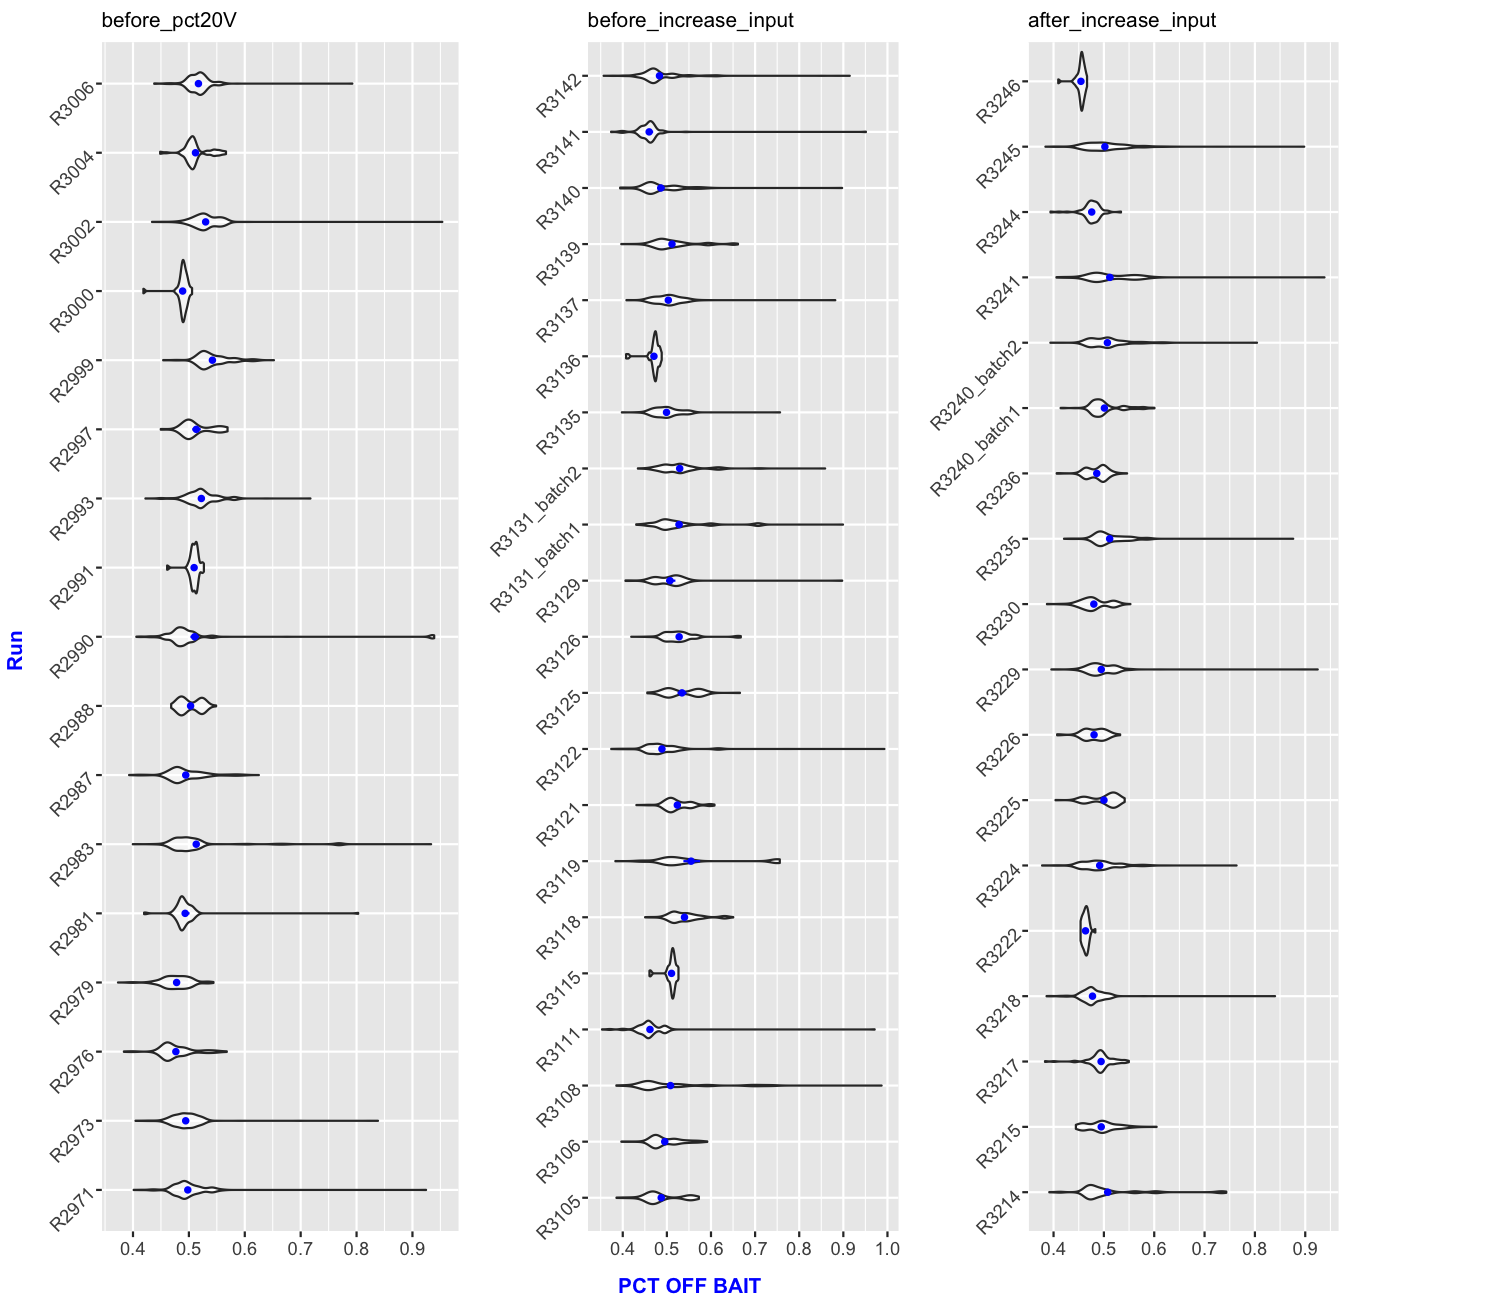

In [318]:
%%R --width 1500 --height 1300 --units px --res 150
library(gridExtra)
library(grid)

ls_p <- list(p1, p2, p3)

# setup layout of graph
# with common axis titles for all sub-graphs.
# cited: https://stackoverflow.com/questions/39008773/ggplot-how-to-add-common-x-and-y-labels-to-a-grid-of-plots
# eipi10's comment
grid.arrange(
            arrangeGrob(
                        grobs = ls_p,
                        ncol = 3, 
                        bottom = textGrob("PCT OFF BAIT", gp=gpar(fontface="bold", col="blue", fontsize=10)), 
                        left = textGrob("Run", gp=gpar(fontface="bold", col="blue", fontsize=10), rot=90)
                      ),
            widths=c(9,1)
)

### Inspecting PCT_OFF_BAIT of each group

#### Method 1: using base ggplot2

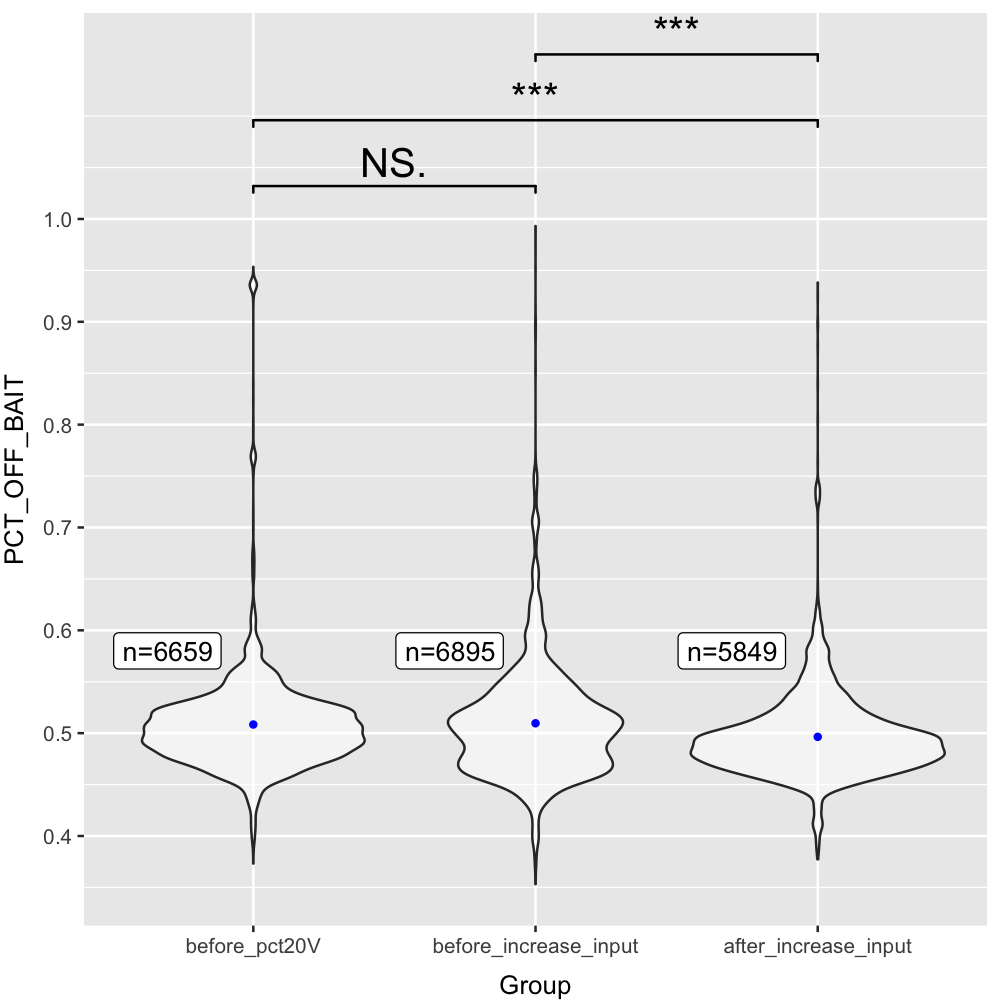

In [428]:
%%R --width 1000 --height 1000 --units px --res 170
library(ggplot2)
library(EnvStats) # for displaying sample size
library(ggsignif)

level = c("before_pct20V", "before_increase_input", "after_increase_input") # for displaying x-axis labels in the right order
ggplot(
        data = full_df,
        aes(
            x = factor(Group, levels = level), # for displaying x-axis labels in the right order
            y = PCT_OFF_BAIT
        )) +
    geom_violin(alpha = 0.5) +
    geom_signif(
                comparisons = list(
                                    c("before_pct20V", "before_increase_input"),
                                    c("before_pct20V", "after_increase_input"),
                                    c("before_increase_input", "after_increase_input")
                                ),
                y_position = 1,
                textsize = 6,
                step_increase = 0.1,
                tip_length = 0.01,
                map_signif_level=TRUE) +
    stat_summary(
                fun.data = "mean_cl_boot",
                geom = "pointrange",
                size = 0.09,
                colour = "blue") +
    theme(
            axis.title.x = element_text(vjust = -1.1),
            axis.title.y = element_text(vjust = 2.5)
        ) +
    stat_n_text(
                y.pos = 0.58, #we can specify where in y axis the samle size should be denoted
                hjust = 1.3, # adjust horizontally
                color = "black", #choose any color
                text.box = TRUE #draws a box outside the n
    ) +
    xlab('Group') +
    scale_y_continuous(breaks=seq(0.4, 1, 0.1))

#### Method 2: using ggplot2 and gridExtra

In [391]:
%%R --width 1000 --height 800 --units px --res 170
library(ggplot2)
library(EnvStats) # for displaying sample size


plot_graph <- function(input_df){
    name <- deparse(substitute(input_df))
    ggplot(data = input_df,
    aes(
        y = PCT_OFF_BAIT,
        x = Group
    )) +
    geom_violin(alpha = 0.5) +
    stat_summary(
                fun.data = "mean_cl_boot",
                geom = "pointrange",
                size = 0.09,
                colour = "blue") +
    theme(
        axis.text.y = element_text(angle = 45)
    ) +
    stat_n_text(
                y.pos = 0.6, #we can specify where in y axis the sample size should be denoted
                hjust = -0.2, # adjust horizontally
                size = 2.5, # adjust text size
                color = "black", #choose any color
                text.box = TRUE #draws a box outside the n
    ) +
    scale_y_continuous(breaks=seq(0.4, 1, 0.1)) +
    coord_fixed(ratio = 4, ylim = c(0.4, 1)) +
    xlab(NULL) +
    ylab(NULL)
}

p1 <- plot_graph(before_pct20V)
p2 <- plot_graph(before_increase_input)
p3 <- plot_graph(after_increase_input)

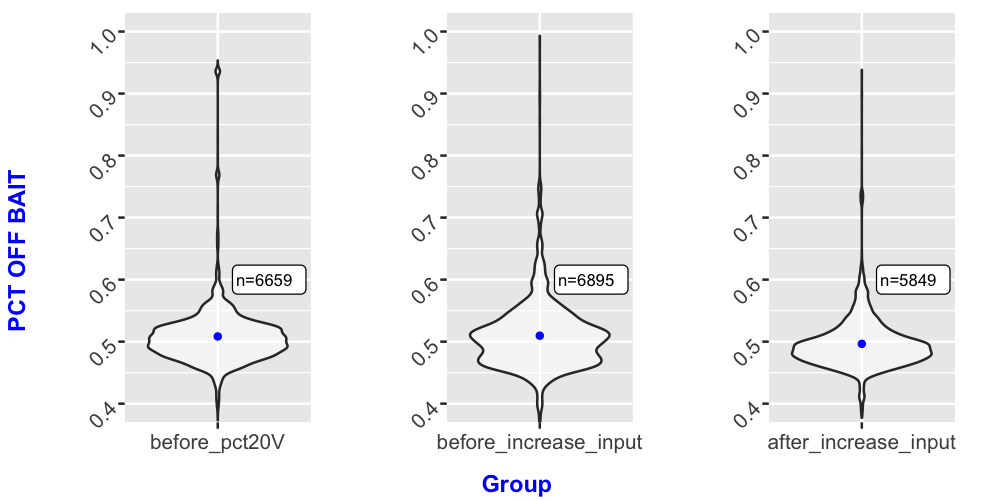

In [392]:
%%R --width 1000 --height 500 --units px --res 170
library(gridExtra)
library(grid)

ls_p <- list(p1, p2, p3)

# setup layout of graph
# with common axis titles for all sub-graphs.
grid.arrange(
            arrangeGrob(
                        grobs = ls_p,
                        ncol = 3, 
                        bottom = textGrob("Group", gp=gpar(fontface="bold", col="blue", fontsize=10)), 
                        left = textGrob("PCT OFF BAIT", gp=gpar(fontface="bold", col="blue", fontsize=10), rot=90)
                      ),
            heights=1,
            widths=1
)


In [413]:
%%R
t.test(PCT_OFF_BAIT ~ Group, 
       full_df, 
       Group %in% c("before_pct20V", "before_increase_input"),
       var.equal = F)


	Welch Two Sample t-test

data:  PCT_OFF_BAIT by Group
t = 1.3541, df = 13528, p-value = 0.1757
alternative hypothesis: true difference in means between group before_increase_input and group before_pct20V is not equal to 0
95 percent confidence interval:
 -0.0005465408  0.0029887672
sample estimates:
mean in group before_increase_input         mean in group before_pct20V 
                          0.5096055                           0.5083844 



In [414]:
%%R
t.test(PCT_OFF_BAIT ~ Group, 
       full_df, 
       Group %in% c("before_pct20V", "after_increase_input"), 
       var.equal = F)


	Welch Two Sample t-test

data:  PCT_OFF_BAIT by Group
t = -14.628, df = 12433, p-value < 2.2e-16
alternative hypothesis: true difference in means between group after_increase_input and group before_pct20V is not equal to 0
95 percent confidence interval:
 -0.01358242 -0.01037253
sample estimates:
mean in group after_increase_input        mean in group before_pct20V 
                         0.4964069                          0.5083844 



In [415]:
%%R
t.test(PCT_OFF_BAIT ~ Group, 
       data = full_df, 
       Group %in% c("before_increase_input", "after_increase_input"),
       var.equal = F)


	Welch Two Sample t-test

data:  PCT_OFF_BAIT by Group
t = -15.569, df = 12570, p-value < 2.2e-16
alternative hypothesis: true difference in means between group after_increase_input and group before_increase_input is not equal to 0
95 percent confidence interval:
 -0.01486028 -0.01153689
sample estimates:
 mean in group after_increase_input mean in group before_increase_input 
                          0.4964069                           0.5096055 



In [419]:
%%R
wilcox.test(PCT_OFF_BAIT ~ Group,
            data = full_df,
            Group %in% c("before_increase_input", "after_increase_input"),
            exact = FALSE)


	Wilcoxon rank sum test with continuity correction

data:  PCT_OFF_BAIT by Group
W = 17006052, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0

